In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [14]:
# Data Preprocessing
# Convert 'SignupDate' to tenure in days
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['TenureDays'] = (pd.Timestamp.now() - customers['SignupDate']).dt.days

In [15]:
# Aggregate transaction data by CustomerID
transactions_agg = transactions.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'TransactionID': 'count'
}).rename(columns={'TransactionID': 'TransactionCount'}).reset_index()

In [16]:
# Merge customer and transaction data
merged_data = pd.merge(customers, transactions_agg, on='CustomerID', how='inner')

In [17]:
# One-hot encode 'Region'
encoder = OneHotEncoder(sparse_output=False)

region_encoded = encoder.fit_transform(merged_data[['Region']])
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))
merged_data = pd.concat([merged_data, region_encoded_df], axis=1)

In [18]:
# Select features for clustering
features = ['TotalValue', 'Quantity', 'TransactionCount', 'TenureDays'] + list(region_encoded_df.columns)
X = merged_data[features]

In [19]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# K-Means Clustering
k = 5  
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
merged_data['Cluster'] = clusters

In [21]:
# Evaluate Clustering Metrics
db_index = davies_bouldin_score(X_scaled, clusters)
silhouette_avg = silhouette_score(X_scaled, clusters)

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

Davies-Bouldin Index: 1.0264771413519012
Silhouette Score: 0.38825163962077747


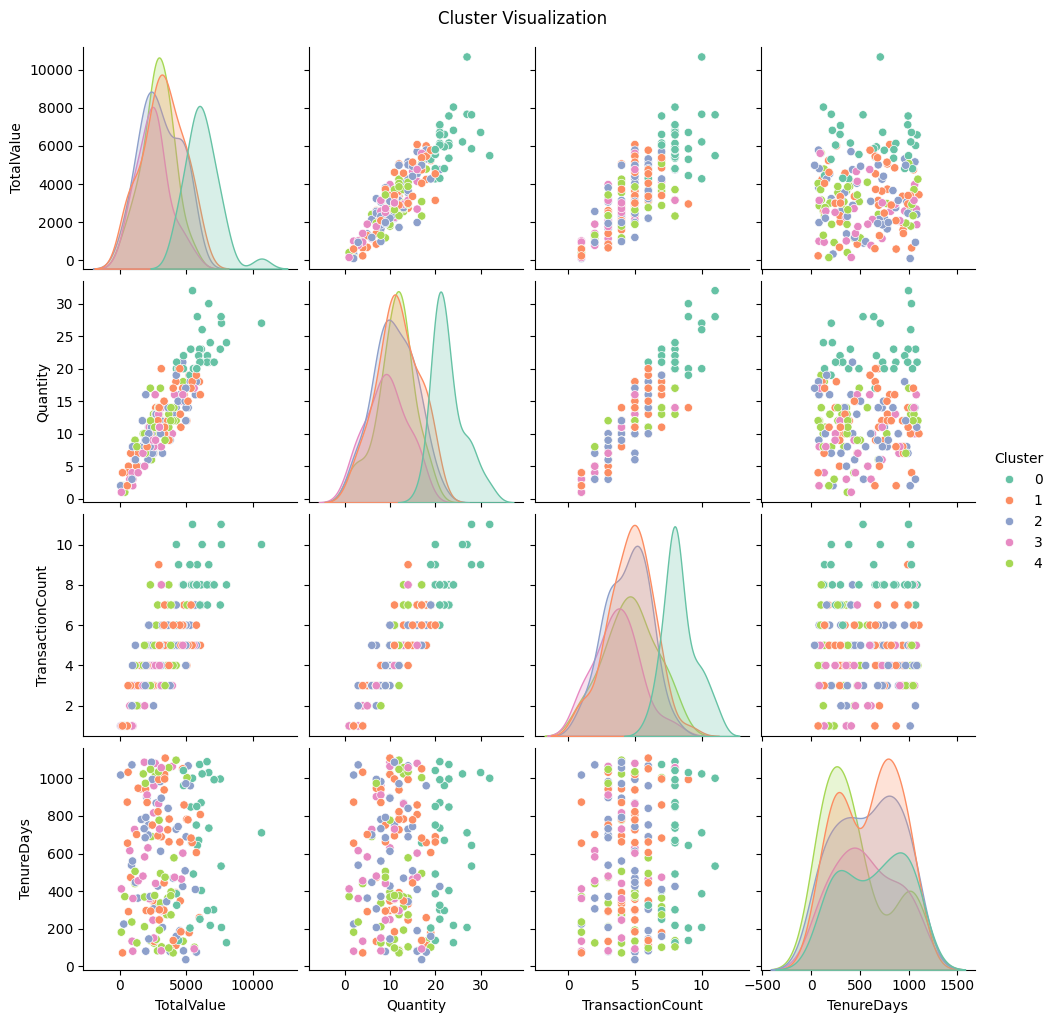

In [22]:
# Visualization: Pairplot of Clusters
sns.pairplot(merged_data, vars=['TotalValue', 'Quantity', 'TransactionCount', 'TenureDays'], hue='Cluster', palette='Set2')
plt.suptitle("Cluster Visualization", y=1.02)
plt.show()